## 0. Setup

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 50)


## 1. Load the Data

In [2]:

players = pd.read_csv("player_data.csv")
stints = pd.read_csv("stint_data.csv")

players.head(), stints.head()


(   player  rating
 0  USA_p1     3.0
 1  USA_p2     3.0
 2  USA_p3     3.5
 3  USA_p4     0.0
 4  USA_p5     2.0,
    game_id h_team a_team   minutes  h_goals  a_goals   home1   home2   home3  \
 0        1    USA  Japan  4.252969        4        9  USA_p4  USA_p1  USA_p3   
 1        1    USA  Japan  5.688809        6       11  USA_p1  USA_p7  USA_p6   
 2        1    USA  Japan  1.149557        0        1  USA_p8  USA_p1  USA_p4   
 3        1    USA  Japan  3.511617        7        5  USA_p2  USA_p7  USA_p8   
 4        1    USA  Japan  2.163139        7        5  USA_p9  USA_p5  USA_p8   
 
     home4      away1      away2      away3      away4  
 0  USA_p6  Japan_p12   Japan_p4   Japan_p8   Japan_p6  
 1  USA_p5   Japan_p7  Japan_p10   Japan_p8  Japan_p12  
 2  USA_p5   Japan_p5   Japan_p3   Japan_p7  Japan_p10  
 3  USA_p6   Japan_p2   Japan_p4  Japan_p10  Japan_p12  
 4  USA_p7   Japan_p8   Japan_p6  Japan_p10   Japan_p1  )

### Observations

- Each player is given a unique id, which includes the team they are on, and a number
- One game has multiple stints, and each stint represents when there's a lineup change or next period
- We see 4 players on the court at one time for each team

## 2. Dataset Size & Coverage

In [3]:

print("Number of stints:", len(stints))
print("Number of games:", stints['game_id'].nunique())
print("Number of teams:", stints[['h_team', 'a_team']].stack().nunique())
print("Number of players:", len(players))
print("Players per team:", len(players) / stints[['h_team', 'a_team']].stack().nunique())


Number of stints: 7448
Number of games: 660
Number of teams: 12
Number of players: 144
Players per team: 12.0


In [4]:
print("stints per game:", len(stints) / stints['game_id'].nunique())

stints per game: 11.284848484848485


- Thousands of stints over 660 games, with the average number of stints being 11.28 per game. This should cover enough of a sample size to be able to track player performance and their interactions with other players
- 12 players per team, and a total of 12 teams, so a total of 144 players

In [5]:
canada_games = stints[
    (stints["h_team"] == "Canada") | (stints["a_team"] == "Canada")
][["game_id", "h_team", "a_team"]].drop_duplicates().sort_values("game_id")

print(canada_games)


      game_id         h_team  a_team
24          3            USA  Canada
153        14          Japan  Canada
287        25  Great.Britain  Canada
385        34         Canada     USA
396        35         Canada   Japan
...       ...            ...     ...
6857      609         Brazil  Canada
6986      620       Columbia  Canada
7106      631         Poland  Canada
7228      642      Argentina  Canada
7353      653          Chile  Canada

[110 rows x 3 columns]


Canada has played 110 games total, which should be enough data to cover trends as each of these games have many stints

In [6]:
# Filter rows where Canada is home or away
canada_stints = stints[
    (stints["h_team"] == "Canada") | (stints["a_team"] == "Canada")
]

# Build a column for "the other team"
canada_stints = canada_stints.assign(
    opp_team=np.where(canada_stints["h_team"] == "Canada",
                      canada_stints["a_team"],
                      canada_stints["h_team"])
)

# Count distinct games vs each opponent
games_vs_each_team = (
    canada_stints[["game_id", "opp_team"]]
    .drop_duplicates()
    .value_counts("opp_team")
    .rename("games_played")
    .reset_index()
)

# Count total stints vs each opponent
stints_vs_each_team = (
    canada_stints
    .value_counts("opp_team")
    .rename("stints_played")
    .reset_index()
)

# Combine
summary_vs_each_team = (
    games_vs_each_team
    .merge(stints_vs_each_team, on="opp_team")
    .sort_values("games_played", ascending=False)
)

print(summary_vs_each_team)


         opp_team  games_played  stints_played
0       Argentina            10            112
1          Brazil            10            110
2           Chile            10            106
3        Columbia            10            112
4         Denmark            10            115
5          France            10            121
6   Great.Britain            10            117
7           Japan            10            117
8          Poland            10            123
9          Sweden            10            118
10            USA            10            112


Canada has played 10 games against each team, with over a hundred stints across those games, which means we have ample data to model the team vs team interactions of each lineup. For example, some lineups may be better to play against Brazil vs. USA, and our model should handle that accordingly.

## 3. Players & Teams

In [7]:
print("list of teams:", stints[['h_team', 'a_team']].stack().unique())

list of teams: ['USA' 'Japan' 'Great.Britain' 'Canada' 'France' 'Denmark' 'Sweden'
 'Brazil' 'Columbia' 'Poland' 'Argentina' 'Chile']


- These are the following teams: 'USA' 'Japan' 'Great.Britain' 'Canada' 'France' 'Denmark' 'Sweden'
 'Brazil' 'Columbia' 'Poland' 'Argentina' 'Chile'

## 4. Stint Duration & Scoring

In [8]:
stints["minutes"].describe()


count    7448.000000
mean        2.843314
std         1.631194
min         0.001582
25%         1.622875
50%         2.582959
75%         3.765502
max         8.000000
Name: minutes, dtype: float64

Stints are typically around 2.84 minutes

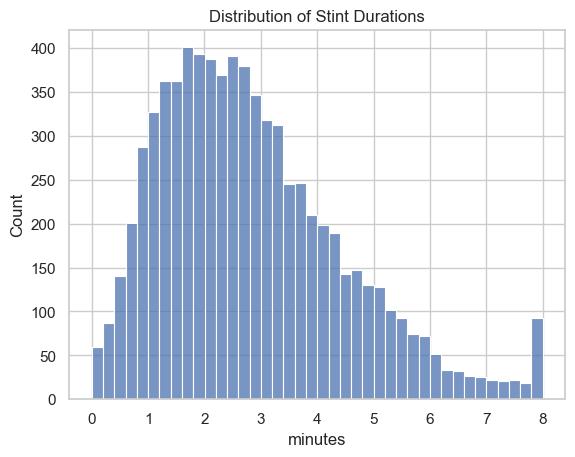

In [9]:
sns.histplot(stints["minutes"], bins=40)
plt.title("Distribution of Stint Durations")
plt.show()


avergae points scored per stint: 8.825859291084855


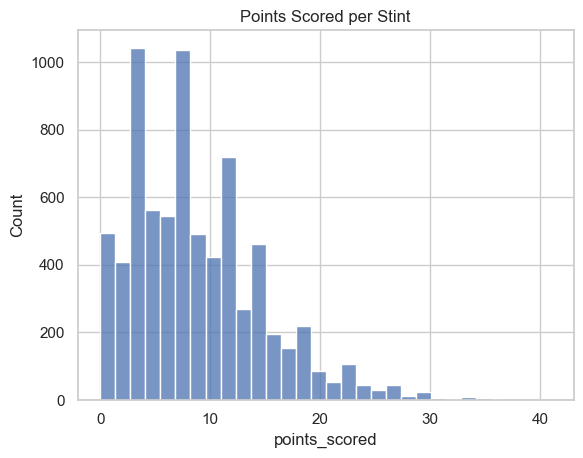

In [10]:

stints["points_scored"] = stints["h_goals"] + stints["a_goals"]
print("avergae points scored per stint:", stints["points_scored"].mean())

sns.histplot(stints["points_scored"], bins=30)
plt.title("Points Scored per Stint")
plt.show()



An Average of 8.8 goals are scored per stint, and it has a lot of variance, so we are curious if this variance can be captured based on looking at which players were on/off and home/away advantages

## Initial Observations

#### Is there enough data?
- Yes there are thousands of stints of data to look at, so we can track performance of different players across enough stints to get a big picture understanding


## CONTINUE...

## 5. Team-Level Performance

Now that we have a good sense of our data, lets dive deeper into team level performance

In [11]:
game_results = []

for _, row in stints.groupby("game_id"):
    game_id = row["game_id"].iloc[0]
    h_team = row["h_team"].iloc[0]
    a_team = row["a_team"].iloc[0]
    
    h_score = row["h_goals"].sum()
    a_score = row["a_goals"].sum()
    
    game_results.append({"game_id": game_id, "team": h_team, "team_score": h_score, "opponent_score": a_score, "home": True})
    game_results.append({"game_id": game_id, "team": a_team, "team_score": a_score, "opponent_score": h_score, "home": False})

game_results = pd.DataFrame(game_results)
game_results["win"] = game_results["team_score"] > game_results["opponent_score"]
game_results.head()


,game_id,team,team_score,opponent_score,home,win
0,1,USA,42,63,True,False
1,1,Japan,63,42,False,True
2,2,USA,45,42,True,True
3,2,Great.Britain,42,45,False,False
4,3,USA,60,28,True,True


In [12]:
team_wins = (
    game_results.groupby("team")["win"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "wins", "count": "games"})
)

team_wins["win_rate"] = team_wins["wins"] / team_wins["games"]
team_wins["team_losses"] = team_wins["games"] - team_wins["wins"]
team_wins.sort_values("win_rate", ascending=False)


,wins,games,win_rate,team_losses
team,,,,
Japan,91,110,0.827273,19
USA,79,110,0.718182,31
France,70,110,0.636364,40
Canada,66,110,0.600000,44
Great.Britain,66,110,0.600000,44
Poland,65,110,0.590909,45
Brazil,63,110,0.572727,47
Denmark,57,110,0.518182,53
Columbia,55,110,0.500000,55


### Observations

- Japan is a clear winner with 91 wins, then USA, France, and Canada

## 6. Home vs Away Advantage

In [13]:

home_away = game_results.groupby("home")["win"].mean()
home_away


home
False    0.428788
True     0.571212
Name: win, dtype: float64

Home Win Rate: 0.5712121212121212
Away Win Rate: 0.4287878787878788


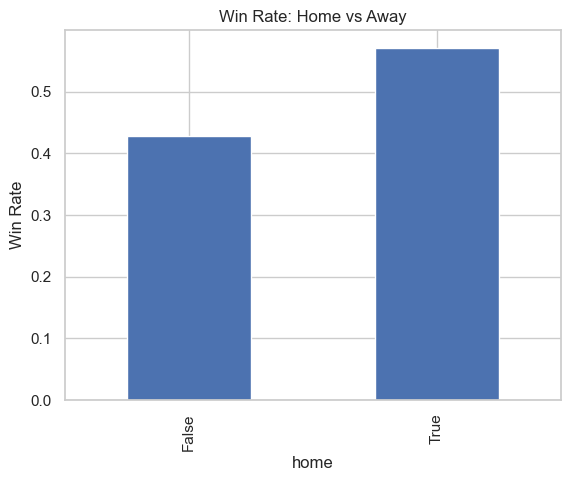

In [14]:

home_away.plot(kind="bar", title="Win Rate: Home vs Away")
print("Home Win Rate:", home_away[True])
print("Away Win Rate:", home_away[False])
plt.ylabel("Win Rate")
plt.show()


### Observations

Playing at home definitely makes a difference, 0.57% win rate at home vs 0.42% win rate away. This means that in our optimization model, we must find a way to account for this bias when we try to optimize the players for maximum wins. This is because the "winning" lineup in the data, may actually be biased by the fact it is a home game, and if that same lineup was played away, it might perform worse than another line-up.

We can:
- Create an optimal line-up per home and away
- Or try to neutralize this bias by including it as some factor in the player optimization model

## 8. Rating vs Performance
Another consideration is how the physical rating effects the performance.

In [15]:
import numpy as np
from collections import defaultdict

home_cols = ["home1","home2","home3","home4"]
away_cols = ["away1","away2","away3","away4"]

# accumulate per-player totals from stints
player_minutes = defaultdict(float)
player_goal_diff = defaultdict(float)

for _, row in stints.iterrows():
    mins = row["minutes"]
    gd = row["h_goals"] - row["a_goals"]

    for p in row[home_cols]:
        player_minutes[p] += mins
        player_goal_diff[p] += gd
    for p in row[away_cols]:
        player_minutes[p] += mins
        player_goal_diff[p] -= gd

player_stats = pd.DataFrame([
    {"player": p,
     "minutes": player_minutes[p],
     "team": p.split("_")[0],
     "lineup_goal_diff_per60": player_goal_diff[p] / player_minutes[p] * 60 if player_minutes[p] > 0 else np.nan}
    for p in player_minutes
])

player_stats = player_stats.merge(players, left_on="player", right_on="player")


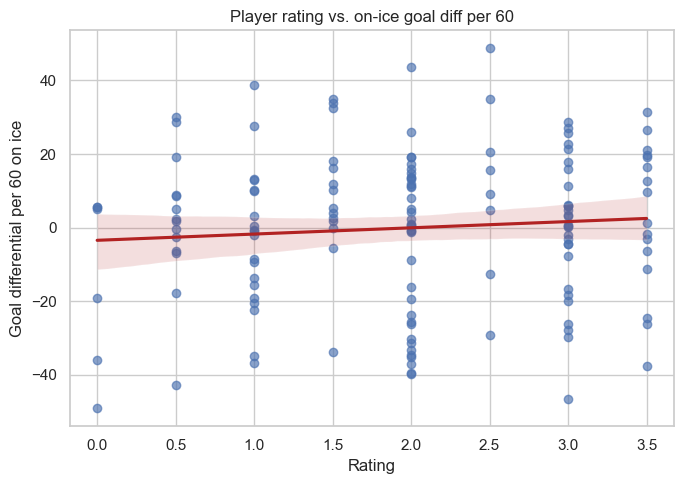

In [16]:
plt.figure(figsize=(7, 5))
sns.regplot(
    data=player_stats,
    x="rating",
    y="lineup_goal_diff_per60",
    scatter_kws={"alpha": 0.65},
    line_kws={"color": "firebrick"},
)
plt.title("Player rating vs. on-ice goal diff per 60")
plt.xlabel("Rating")
plt.ylabel("Goal differential per 60 on ice")
plt.grid(True)
plt.tight_layout()


### Observations

We see that there is somewhat of a difference in goal differential due to rating

## 9. Notes for Model Feasability

- Which metrics feel noisy?
- Which teams or players stand out?
- Which constraints matter most for optimization?
- What data might be missing?

_Write your thoughts here._

## Canada win rate / goal diff vs opponent, split by home/away
Shows matchup + home effects exist (supports interaction terms)


Canada games: 110
Home/Away balance (games):
home_str
Home    55
Away    55
Name: count, dtype: int64


,opponent,home_str,games,win_rate,avg_goal_diff
0,Argentina,Away,5,0.8,13.4
1,Argentina,Home,5,1.0,27.4
2,Brazil,Away,5,0.6,6.6
3,Brazil,Home,5,0.6,6.8
4,Chile,Away,5,0.6,7.0
5,Chile,Home,5,0.8,7.8
6,Columbia,Away,5,0.2,-8.8
7,Columbia,Home,5,0.8,14.2
8,Denmark,Away,5,1.0,11.8
9,Denmark,Home,5,0.8,2.4


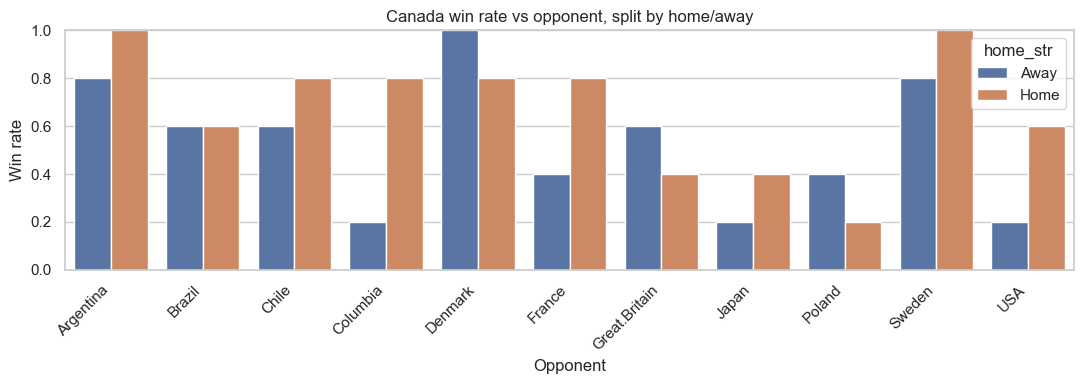

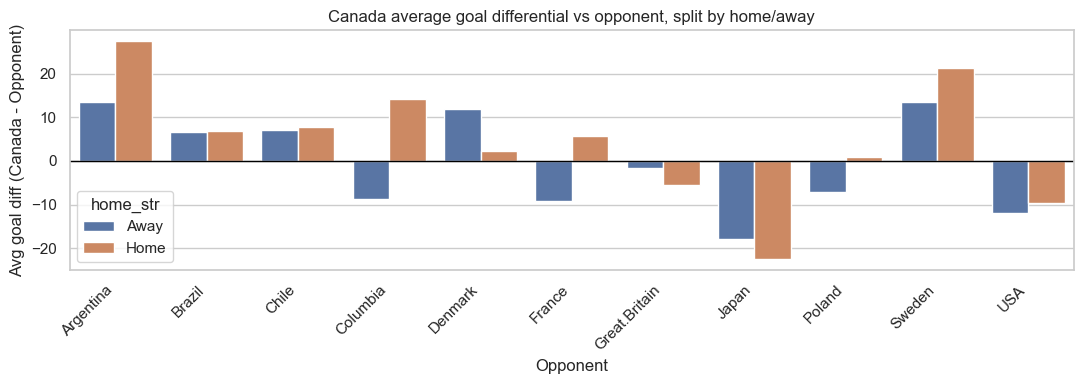

In [17]:
# Build per-game results with opponent + home/away
# (This avoids double-counting from stint-level rows.)
games = (
    stints.groupby("game_id")
    .agg(
        h_team=("h_team", "first"),
        a_team=("a_team", "first"),
        h_score=("h_goals", "sum"),
        a_score=("a_goals", "sum"),
        minutes=("minutes", "sum"),
    )
    .reset_index()
)

game_long = pd.concat(
    [
        games.assign(
            team=games["h_team"],
            opponent=games["a_team"],
            team_score=games["h_score"],
            opponent_score=games["a_score"],
            home=True,
        ),
        games.assign(
            team=games["a_team"],
            opponent=games["h_team"],
            team_score=games["a_score"],
            opponent_score=games["h_score"],
            home=False,
        ),
    ],
    ignore_index=True,
)

game_long["win"] = game_long["team_score"] > game_long["opponent_score"]
game_long["goal_diff"] = game_long["team_score"] - game_long["opponent_score"]
game_long["home_str"] = np.where(game_long["home"], "Home", "Away")

canada_games_long = game_long[game_long["team"] == "Canada"].copy()

print("Canada games:", canada_games_long["game_id"].nunique())
print("Home/Away balance (games):")
print(canada_games_long.drop_duplicates(["game_id", "home_str"])["home_str"].value_counts())

matchup_home = (
    canada_games_long.groupby(["opponent", "home_str"])
    .agg(
        games=("game_id", "nunique"),
        win_rate=("win", "mean"),
        avg_goal_diff=("goal_diff", "mean"),
    )
    .reset_index()
    .sort_values(["opponent", "home_str"])
)

display(matchup_home)

plt.figure(figsize=(11, 4))
sns.barplot(data=matchup_home, x="opponent", y="win_rate", hue="home_str")
plt.title("Canada win rate vs opponent, split by home/away")
plt.ylabel("Win rate")
plt.xlabel("Opponent")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4))
sns.barplot(data=matchup_home, x="opponent", y="avg_goal_diff", hue="home_str")
plt.axhline(0, color="black", linewidth=1)
plt.title("Canada average goal differential vs opponent, split by home/away")
plt.ylabel("Avg goal diff (Canada - Opponent)")
plt.xlabel("Opponent")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Aggregated home vs away effect (Canada)

Aggregate across all Canada games to quantify the home/away effect directly (with a simple bootstrap CI).

,games,win_rate,avg_goal_diff
home_str,,,
Away,55,0.527273,-0.363636
Home,55,0.672727,4.472727


Canada home-away win-rate diff: 0.145 (95% CI -0.036, 0.327)
Canada home-away goal-diff diff: 4.836 (95% CI -3.019, 12.365)


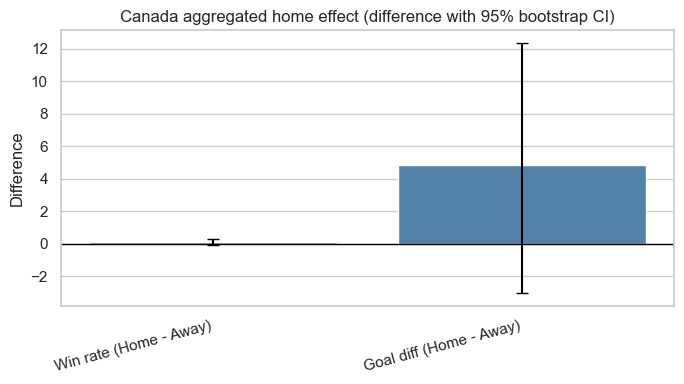

In [18]:
# Aggregate Canada home vs away and plot the *difference* (Home - Away)
canada_agg = (
    canada_games_long.groupby("home_str")
    .agg(games=("game_id", "nunique"), win_rate=("win", "mean"), avg_goal_diff=("goal_diff", "mean"))
    .reset_index()
    .set_index("home_str")
)

display(canada_agg)

home_win = float(canada_agg.loc["Home", "win_rate"])
away_win = float(canada_agg.loc["Away", "win_rate"])
home_gd = float(canada_agg.loc["Home", "avg_goal_diff"])
away_gd = float(canada_agg.loc["Away", "avg_goal_diff"])

win_diff = home_win - away_win
gd_diff = home_gd - away_gd

# Bootstrap CI over games (resample games within home/away)
B = 2000
rng = np.random.default_rng(0)

can_home = canada_games_long[canada_games_long["home"]].drop_duplicates("game_id")
can_away = canada_games_long[~canada_games_long["home"]].drop_duplicates("game_id")

home_win_arr = can_home["win"].to_numpy(dtype=float)
away_win_arr = can_away["win"].to_numpy(dtype=float)
home_gd_arr = can_home["goal_diff"].to_numpy(dtype=float)
away_gd_arr = can_away["goal_diff"].to_numpy(dtype=float)

boot_win = []
boot_gd = []
for _ in range(B):
    h_idx = rng.integers(0, len(home_win_arr), size=len(home_win_arr))
    a_idx = rng.integers(0, len(away_win_arr), size=len(away_win_arr))
    boot_win.append(home_win_arr[h_idx].mean() - away_win_arr[a_idx].mean())
    boot_gd.append(home_gd_arr[h_idx].mean() - away_gd_arr[a_idx].mean())

win_ci = (np.percentile(boot_win, 2.5), np.percentile(boot_win, 97.5))
gd_ci = (np.percentile(boot_gd, 2.5), np.percentile(boot_gd, 97.5))

print(f"Canada home-away win-rate diff: {win_diff:.3f} (95% CI {win_ci[0]:.3f}, {win_ci[1]:.3f})")
print(f"Canada home-away goal-diff diff: {gd_diff:.3f} (95% CI {gd_ci[0]:.3f}, {gd_ci[1]:.3f})")

plt.figure(figsize=(7, 4))
diff_df = pd.DataFrame(
    {
        "metric": ["Win rate (Home - Away)", "Goal diff (Home - Away)"],
        "diff": [win_diff, gd_diff],
        "lo": [win_ci[0], gd_ci[0]],
        "hi": [win_ci[1], gd_ci[1]],
    }
)

sns.barplot(data=diff_df, x="metric", y="diff", color="steelblue")
plt.errorbar(
    x=np.arange(len(diff_df)),
    y=diff_df["diff"],
    yerr=[diff_df["diff"] - diff_df["lo"], diff_df["hi"] - diff_df["diff"]],
    fmt="none",
    ecolor="black",
    capsize=4,
)
plt.axhline(0, color="black", linewidth=1)
plt.title("Canada aggregated home effect (difference with 95% bootstrap CI)")
plt.ylabel("Difference")
plt.xlabel("")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

### Home/away impact by team (not just Canada)

Compute each team’s home-vs-away difference in win rate and goal differential.

,games_home,games_away,win_rate_home,win_rate_away,avg_goal_diff_home,avg_goal_diff_away,win_rate_diff,goal_diff_diff
team,,,,,,,,
Great.Britain,55.0,55.0,0.709091,0.490909,9.400000,1.709091,0.218182,7.690909
Brazil,55.0,55.0,0.672727,0.472727,5.254545,-1.254545,0.200000,6.509091
Poland,55.0,55.0,0.690909,0.490909,5.581818,-0.563636,0.200000,6.145455
France,55.0,55.0,0.727273,0.545455,8.600000,1.927273,0.181818,6.672727
USA,55.0,55.0,0.800000,0.636364,13.563636,9.145455,0.163636,4.418182
Canada,55.0,55.0,0.672727,0.527273,4.472727,-0.363636,0.145455,4.836364
Chile,55.0,55.0,0.272727,0.145455,-8.600000,-14.381818,0.127273,5.781818
Denmark,55.0,55.0,0.581818,0.454545,3.672727,-0.690909,0.127273,4.363636
Japan,55.0,55.0,0.890909,0.763636,15.890909,14.800000,0.127273,1.090909


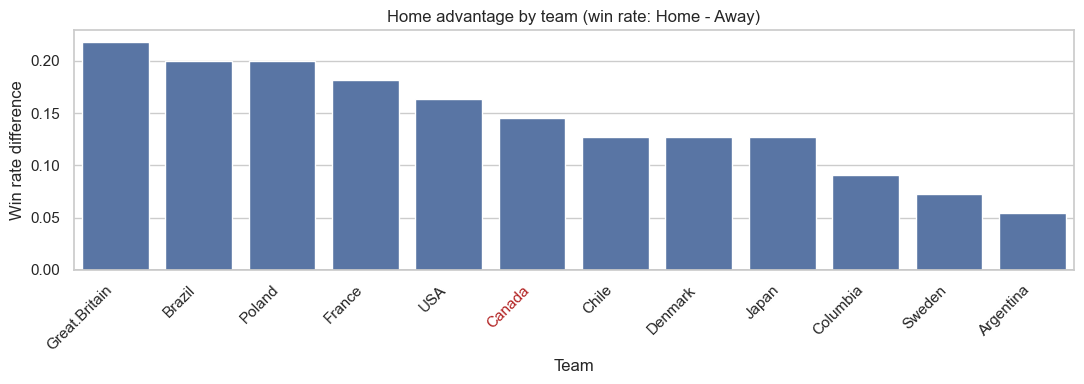

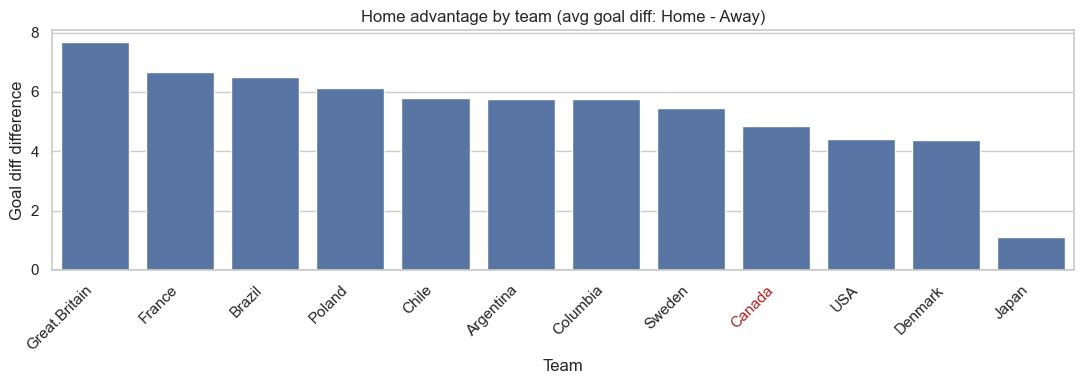

In [19]:
# Per-team home advantage: Home - Away
team_home_away = (
    game_long.groupby(["team", "home_str"])
    .agg(games=("game_id", "nunique"), win_rate=("win", "mean"), avg_goal_diff=("goal_diff", "mean"))
    .reset_index()
)

team_pivot = team_home_away.pivot(index="team", columns="home_str", values=["games", "win_rate", "avg_goal_diff"])

team_effect = pd.DataFrame(
    {
        "games_home": team_pivot[("games", "Home")],
        "games_away": team_pivot[("games", "Away")],
        "win_rate_home": team_pivot[("win_rate", "Home")],
        "win_rate_away": team_pivot[("win_rate", "Away")],
        "avg_goal_diff_home": team_pivot[("avg_goal_diff", "Home")],
        "avg_goal_diff_away": team_pivot[("avg_goal_diff", "Away")],
    }
)

team_effect["win_rate_diff"] = team_effect["win_rate_home"] - team_effect["win_rate_away"]
team_effect["goal_diff_diff"] = team_effect["avg_goal_diff_home"] - team_effect["avg_goal_diff_away"]

team_effect = team_effect.sort_values("win_rate_diff", ascending=False)
display(team_effect)

plt.figure(figsize=(11, 4))
order = team_effect.index.tolist()
sns.barplot(x=order, y=team_effect["win_rate_diff"].to_numpy())
plt.axhline(0, color="black", linewidth=1)
plt.title("Home advantage by team (win rate: Home - Away)")
plt.ylabel("Win rate difference")
plt.xlabel("Team")
plt.xticks(rotation=45, ha="right")
# highlight Canada if present
if "Canada" in team_effect.index:
    idx = order.index("Canada")
    plt.gca().get_xticklabels()[idx].set_color("firebrick")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4))
team_effect2 = team_effect.sort_values("goal_diff_diff", ascending=False)
order2 = team_effect2.index.tolist()
sns.barplot(x=order2, y=team_effect2["goal_diff_diff"].to_numpy())
plt.axhline(0, color="black", linewidth=1)
plt.title("Home advantage by team (avg goal diff: Home - Away)")
plt.ylabel("Goal diff difference")
plt.xlabel("Team")
plt.xticks(rotation=45, ha="right")
if "Canada" in team_effect2.index:
    idx = order2.index("Canada")
    plt.gca().get_xticklabels()[idx].set_color("firebrick")
plt.tight_layout()
plt.show()

### Conclusions + hypothesis (home/away advantage)

**Hypothesis (testable):**
- H0: No home advantage (Home − Away = 0)
- H1: Home advantage exists (Home − Away > 0) in win rate and/or average goal differential

**How to interpret the plots above:**
- If Canada’s 95% bootstrap CI for (Home − Away) excludes 0, that’s evidence the home/away context materially changes outcomes for Canada.
- If many teams show positive (Home − Away), the effect looks systemic; if it varies by team (some positive, some negative), that supports adding team × home interaction terms.

**Result statement template (fill with printed numbers):**
- “Canada shows a home advantage of Δwin = {…} and Δgoal_diff = {…}; the bootstrap 95% CI for Δwin {does/does not} exclude 0 (p = {…}). This suggests home/away context is {material / not clearly material} and should {be included / be investigated further} in the model.”


In [22]:
# Quantify strength of evidence for write-up

# Canada: two-sided bootstrap p-values for Home - Away
B = 2000
rng = np.random.default_rng(0)

can_home = canada_games_long[canada_games_long["home"]].drop_duplicates("game_id")
can_away = canada_games_long[~canada_games_long["home"]].drop_duplicates("game_id")

home_win_arr = can_home["win"].to_numpy(dtype=float)
away_win_arr = can_away["win"].to_numpy(dtype=float)
home_gd_arr = can_home["goal_diff"].to_numpy(dtype=float)
away_gd_arr = can_away["goal_diff"].to_numpy(dtype=float)

boot_win = []
boot_gd = []
for _ in range(B):
    h_idx = rng.integers(0, len(home_win_arr), size=len(home_win_arr))
    a_idx = rng.integers(0, len(away_win_arr), size=len(away_win_arr))
    boot_win.append(home_win_arr[h_idx].mean() - away_win_arr[a_idx].mean())
    boot_gd.append(home_gd_arr[h_idx].mean() - away_gd_arr[a_idx].mean())

boot_win = np.asarray(boot_win)
boot_gd = np.asarray(boot_gd)

obs_win = home_win_arr.mean() - away_win_arr.mean()
obs_gd = home_gd_arr.mean() - away_gd_arr.mean()

p_win = (np.abs(boot_win) >= abs(obs_win)).mean()
p_gd = (np.abs(boot_gd) >= abs(obs_gd)).mean()

print(f"Canada Δwin (Home-Away) = {obs_win:.3f}; bootstrap p(two-sided) = {p_win:.3f}")
print(f"Canada Δgoal_diff (Home-Away) = {obs_gd:.3f}; bootstrap p(two-sided) = {p_gd:.3f}")

# All teams: summarize how widespread the home effect is
team_summary = team_effect.copy()
team_summary = team_summary.dropna(subset=["win_rate_diff", "goal_diff_diff"])

print("Across teams:")
print(f"Teams with positive Δwin: {(team_summary["win_rate_diff"] > 0).mean():.2%}")
print(f"Median Δwin: {team_summary["win_rate_diff"].median():.3f}")
print(f"Teams with positive Δgoal_diff: {(team_summary["goal_diff_diff"] > 0).mean():.2%}")
print(f"Median Δgoal_diff: {team_summary["goal_diff_diff"].median():.3f}")

# Teams with largest absolute differences (potential interaction-term evidence)
print("Largest |Δwin| teams:")
display(team_summary.reindex(team_summary["win_rate_diff"].abs().sort_values(ascending=False).head(5).index)[["games_home","games_away","win_rate_diff"]])

print("Largest |Δgoal_diff| teams:")
display(team_summary.reindex(team_summary["goal_diff_diff"].abs().sort_values(ascending=False).head(5).index)[["games_home","games_away","goal_diff_diff"]])


Canada Δwin (Home-Away) = 0.145; bootstrap p(two-sided) = 0.529
Canada Δgoal_diff (Home-Away) = 4.836; bootstrap p(two-sided) = 0.527
Across teams:
Teams with positive Δwin: 100.00%
Median Δwin: 0.136
Teams with positive Δgoal_diff: 100.00%
Median Δgoal_diff: 5.755
Largest |Δwin| teams:


,games_home,games_away,win_rate_diff
team,,,
Great.Britain,55.0,55.0,0.218182
Brazil,55.0,55.0,0.200000
Poland,55.0,55.0,0.200000
France,55.0,55.0,0.181818
USA,55.0,55.0,0.163636


Largest |Δgoal_diff| teams:


,games_home,games_away,goal_diff_diff
team,,,
Great.Britain,55.0,55.0,7.690909
France,55.0,55.0,6.672727
Brazil,55.0,55.0,6.509091
Poland,55.0,55.0,6.145455
Chile,55.0,55.0,5.781818


## Opponent “strength” proxies

average goals scored per minute by opponent (offense)

average goals conceded per minute by opponent (defense)

optionally Elo-like win strength

This justifies why you normalize via opponent effects.


,gf_per_min,ga_per_min,gd_per_min
team,,,
Japan,1.750000,1.272084,0.477916
USA,1.729438,1.375213,0.354226
Great.Britain,1.623516,1.450820,0.172696
France,1.618913,1.454983,0.163930
Poland,1.527134,1.449124,0.078010
Canada,1.610040,1.545944,0.064095
Brazil,1.575234,1.512893,0.062341
Denmark,1.647727,1.601136,0.046591
Columbia,1.444790,1.437995,0.006795


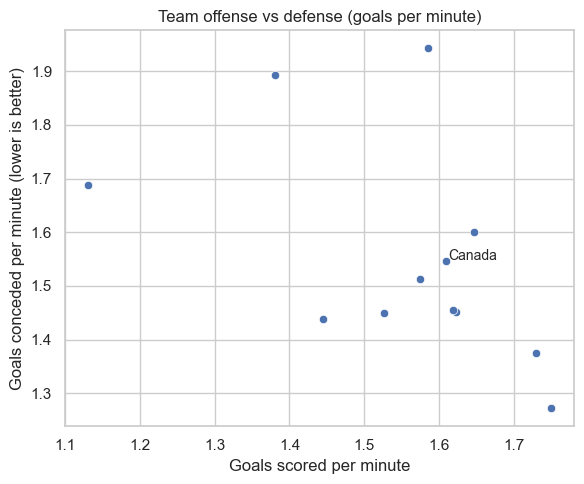

In [20]:
# Offense/defense proxies from stint-level totals
home_totals = (
    stints.groupby("h_team")
    .agg(goals_for=("h_goals", "sum"), goals_against=("a_goals", "sum"), minutes=("minutes", "sum"))
    .rename_axis("team")
)
away_totals = (
    stints.groupby("a_team")
    .agg(goals_for=("a_goals", "sum"), goals_against=("h_goals", "sum"), minutes=("minutes", "sum"))
    .rename_axis("team")
)

team_totals = home_totals.add(away_totals, fill_value=0)
team_strength = team_totals.assign(
    gf_per_min=lambda d: d["goals_for"] / d["minutes"],
    ga_per_min=lambda d: d["goals_against"] / d["minutes"],
    gd_per_min=lambda d: (d["goals_for"] - d["goals_against"]) / d["minutes"],
)[["gf_per_min", "ga_per_min", "gd_per_min"]]

team_strength = team_strength.sort_values("gd_per_min", ascending=False)
display(team_strength)

plt.figure(figsize=(6, 5))
df_scatter = team_strength.reset_index()
sns.scatterplot(data=df_scatter, x="gf_per_min", y="ga_per_min")
if (df_scatter["team"] == "Canada").any():
    r = df_scatter[df_scatter["team"] == "Canada"].iloc[0]
    plt.text(r["gf_per_min"] + 0.003, r["ga_per_min"] + 0.003, "Canada", fontsize=10)
plt.title("Team offense vs defense (goals per minute)")
plt.xlabel("Goals scored per minute")
plt.ylabel("Goals conceded per minute (lower is better)")
plt.tight_layout()
plt.show()
